# Problématique

<h3> Prédire le mot dans l'image </h3>

- Création de dataset Tensorflow pour faire des traitements par lots et pouvoir utiliser toutes les images de la base pour le modele
- Modèle Deep learning : RNN
- Évaluation du modèle : ?


# Import

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd


In [2]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)

<module 'rendering' from 'd:\\VSCode-Folder\\OCRpyMAN\\notebooks\\rendering.py'>

# Chargement du dataframe

In [3]:
# initialisation des variables globales
rss.init()

In [4]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, X_test, y_test = ld_util.get_dataset(augmented=True)

Instructions for updating:
delimiter is deprecated, please use sep instead.


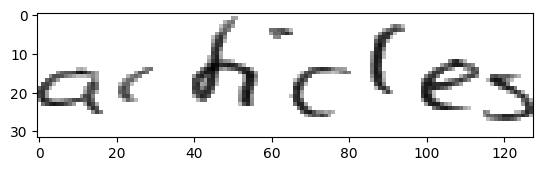

In [5]:
### TEST - TODELETE ###
# Visualisation du contenu du dataset créé au-dessus


from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
        
x, y = next(iter(dataset_train))
x[0].shape

tmp = x[10]
# tmp = tf.squeeze(tmp, axis=2)
# tmp = np.swapaxes(tmp, 0, 1)
# tmp = tmp.reshape(128,32)
plt.imshow(tmp , cmap='gray');  # .reshape(rss.img_size)




### Affichage des données preprocessées

In [6]:
batch_id=0
iterator = iter(dataset_train)

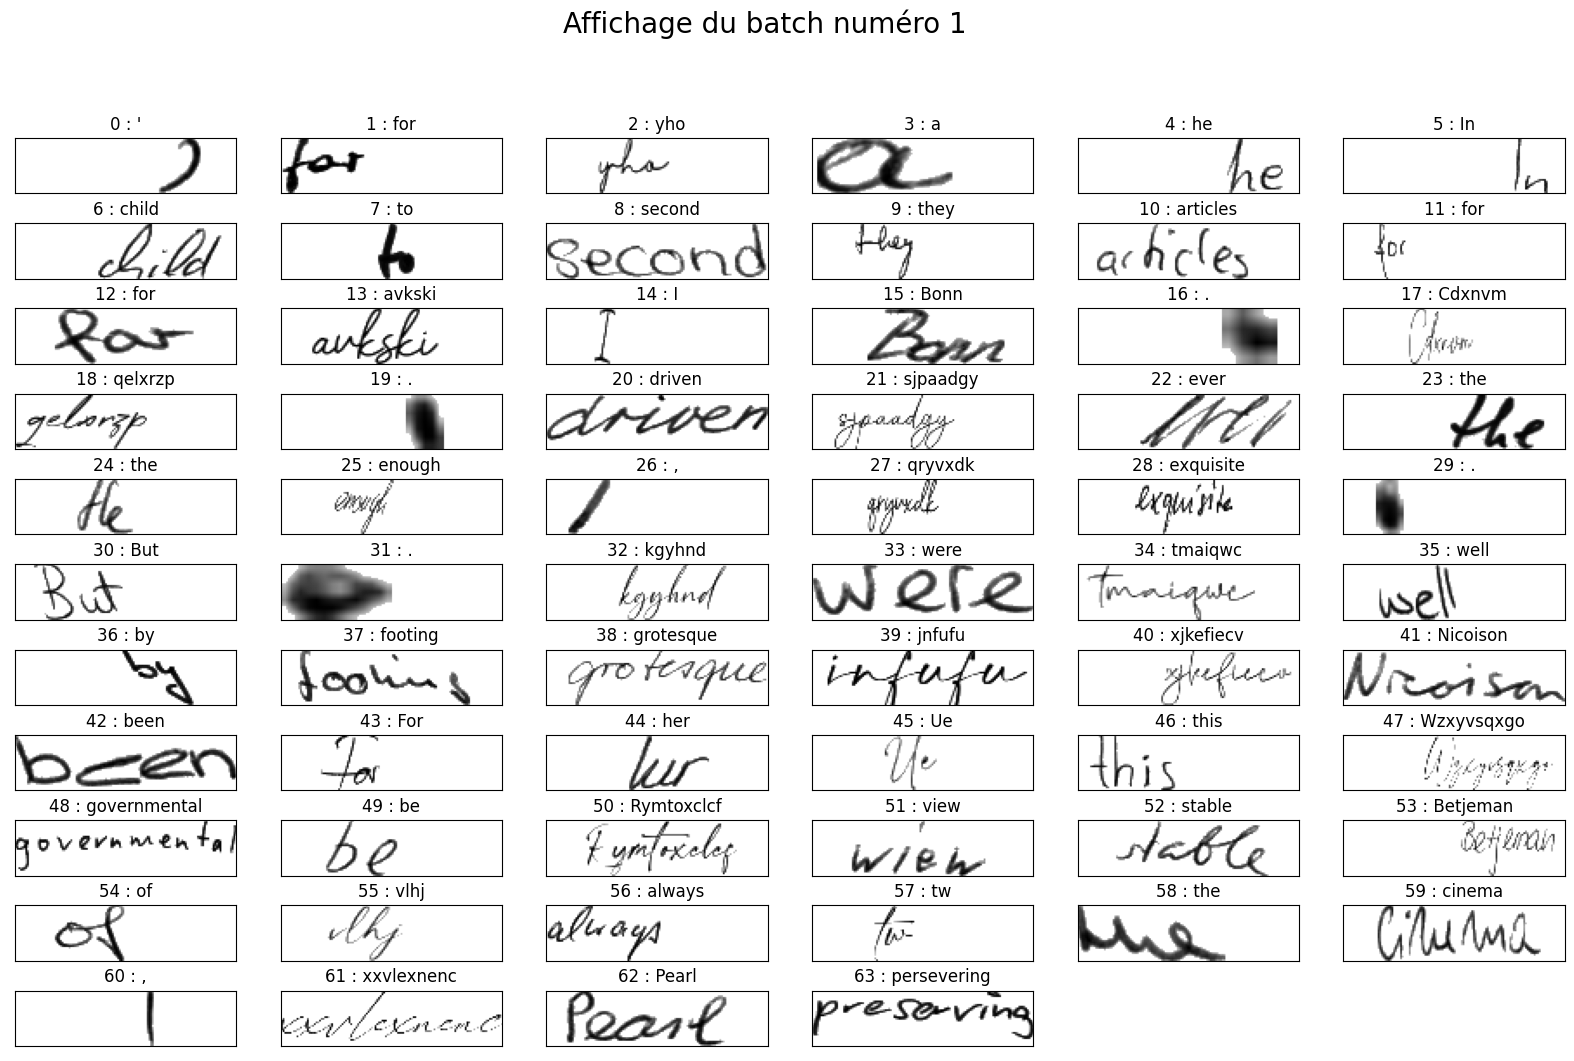

In [7]:
x,y = iterator.get_next()
batch_id +=1
rd.show_iterator_batch(x,y,batch_id)

# Model RNN

### Création Modèle

In [8]:
model = mdl.create_modele()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 32)      128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 64)       2

In [9]:

# Pour stopper l'apprentissage si la val_loss n'évolue plus
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    restore_best_weights=True
)

# Backup temporaire du modele à chaque epoch. Pour restaurer, utiliser : model.load_weights('tmp_model')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

# ajouter un ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    mode='min',
    min_delta=0.1,
    min_lr=0.00001
)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=mdl.CTCLoss(), optimizer=optimizer)
history = model.fit(
    dataset_train,
    validation_data=dataset_test,
    callbacks=[
        early_stop_callback,
        checkpoint_callback,
        reduce_lr
    ],
    epochs=20
)

Epoch 1/20
2031/2031 [==============================] - ETA: 0s - loss: 6.5055

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 211s 100ms/step - loss: 6.5055 - val_loss: 37.4005 - lr: 0.0010
Epoch 2/20
2030/2031 [============================>.] - ETA: 0s - loss: 2.6974

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 174s 86ms/step - loss: 2.6973 - val_loss: 2.5437 - lr: 0.0010
Epoch 3/20
2031/2031 [==============================] - 161s 79ms/step - loss: 2.1327 - val_loss: 4.5898 - lr: 0.0010
Epoch 4/20
2031/2031 [==============================] - 173s 85ms/step - loss: 1.8401 - val_loss: 4.0304 - lr: 0.0010
Epoch 5/20
2030/2031 [============================>.] - ETA: 0s - loss: 1.3018

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 179s 88ms/step - loss: 1.3019 - val_loss: 1.5289 - lr: 2.0000e-04
Epoch 6/20
2030/2031 [============================>.] - ETA: 0s - loss: 1.1668

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 179s 88ms/step - loss: 1.1668 - val_loss: 1.5208 - lr: 2.0000e-04
Epoch 7/20
2031/2031 [==============================] - 166s 82ms/step - loss: 1.0972 - val_loss: 1.5217 - lr: 2.0000e-04
Epoch 8/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.9867

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 181s 89ms/step - loss: 0.9867 - val_loss: 1.3493 - lr: 4.0000e-05
Epoch 9/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.9461

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 184s 90ms/step - loss: 0.9461 - val_loss: 1.2687 - lr: 4.0000e-05
Epoch 10/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.9286

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 186s 92ms/step - loss: 0.9287 - val_loss: 1.2595 - lr: 4.0000e-05
Epoch 11/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.8991

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 186s 92ms/step - loss: 0.8991 - val_loss: 1.2401 - lr: 1.0000e-05
Epoch 12/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.8942

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 187s 92ms/step - loss: 0.8942 - val_loss: 1.2327 - lr: 1.0000e-05
Epoch 13/20
2031/2031 [==============================] - 171s 84ms/step - loss: 0.8889 - val_loss: 1.2382 - lr: 1.0000e-05
Epoch 14/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.8864

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 187s 92ms/step - loss: 0.8864 - val_loss: 1.2254 - lr: 1.0000e-05
Epoch 15/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.8786

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 190s 94ms/step - loss: 0.8786 - val_loss: 1.2152 - lr: 1.0000e-05
Epoch 16/20
2031/2031 [==============================] - 172s 85ms/step - loss: 0.8794 - val_loss: 1.2320 - lr: 1.0000e-05
Epoch 17/20
2031/2031 [==============================] - 172s 85ms/step - loss: 0.8706 - val_loss: 1.2252 - lr: 1.0000e-05
Epoch 18/20
2031/2031 [==============================] - 172s 85ms/step - loss: 0.8768 - val_loss: 1.2213 - lr: 1.0000e-05
Epoch 19/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.8706

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 187s 92ms/step - loss: 0.8706 - val_loss: 1.2118 - lr: 1.0000e-05
Epoch 20/20
2030/2031 [============================>.] - ETA: 0s - loss: 0.8624

INFO:tensorflow:Assets written to: tmp_model\assets


INFO:tensorflow:Assets written to: tmp_model\assets


2031/2031 [==============================] - 197s 97ms/step - loss: 0.8624 - val_loss: 1.2068 - lr: 1.0000e-05


In [10]:
# Sauvegarde et/ou rechargement de l'history dans un pickle et du modele  : décommenter la partie voulue
### ATTENTION ### un historique créé sur une autre machine ne peut pas se charger...

#Sauvegarde historique
# with open('../pickle/tj_ctc_augmented_20epochs_LR-plateau.pickle', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

#Rechargement historique
# with open('../pickle/tj_ctc_model_10_history.pickle', "rb") as file_pi:
#     history = pickle.load(file_pi)


# Sauvegarde/Chargement du modele
# model.save('../pickle/tj_ctc_augmented_20epochs_LR-plateau')
# model = tf.keras.models.load_model("../pickle/tj_ctc_model_10", custom_objects={"CTCLoss": mdl.CTCLoss})

INFO:tensorflow:Assets written to: ../pickle/tj_ctc_augmented_20epochs_LR-plateau\assets


INFO:tensorflow:Assets written to: ../pickle/tj_ctc_augmented_20epochs_LR-plateau\assets


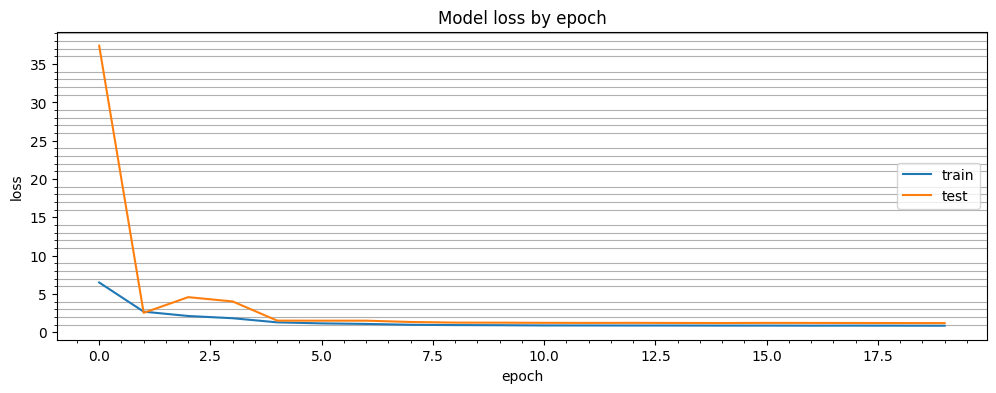

In [11]:
# Affichage des courbes de perte    

mdl.show_loss(history.history)

In [12]:
print(history.history)

{'loss': [6.505460262298584, 2.6973302364349365, 2.1326651573181152, 1.8400709629058838, 1.3018866777420044, 1.1667612791061401, 1.0972429513931274, 0.9866938591003418, 0.9460581541061401, 0.9286639094352722, 0.8991035223007202, 0.8941988945007324, 0.8888919949531555, 0.8864210247993469, 0.8785842061042786, 0.8793959021568298, 0.8705869913101196, 0.876787006855011, 0.8706390261650085, 0.8623507022857666], 'val_loss': [37.40047836303711, 2.5437092781066895, 4.589788913726807, 4.0304107666015625, 1.5289157629013062, 1.5208191871643066, 1.5217409133911133, 1.3493224382400513, 1.2687454223632812, 1.2594983577728271, 1.240094780921936, 1.2326829433441162, 1.2381850481033325, 1.2253546714782715, 1.215232014656067, 1.2319786548614502, 1.225151777267456, 1.2213371992111206, 1.2117522954940796, 1.2067593336105347], 'lr': [0.001, 0.001, 0.001, 0.001, 0.00020000001, 0.00020000001, 0.00020000001, 4.0000003e-05, 4.0000003e-05, 4.0000003e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1

In [13]:
# Apperçu du résultat avec quelque prédictions

y_pred = model.predict(dataset_test)
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
eval_data = list(zip(y_test, predicted_transcriptions))

eval_df = pd.DataFrame(data=np.array(eval_data), columns=['real', 'predicted'])
eval_df.head(10)

eval_df['cer'] = [ld_util.evaluate_character_level_accuracy(row.real, row.predicted) for index, row in eval_df.iterrows()]

print("Notre modèle a une précision par mot de", eval_df['cer'].mean(), ' pour ', eval_df.shape[0], ' mots.')



226/226 [==============================] - 19s 78ms/step
Notre modèle a une précision par mot de 0.9298283375868897  pour  14437  mots.


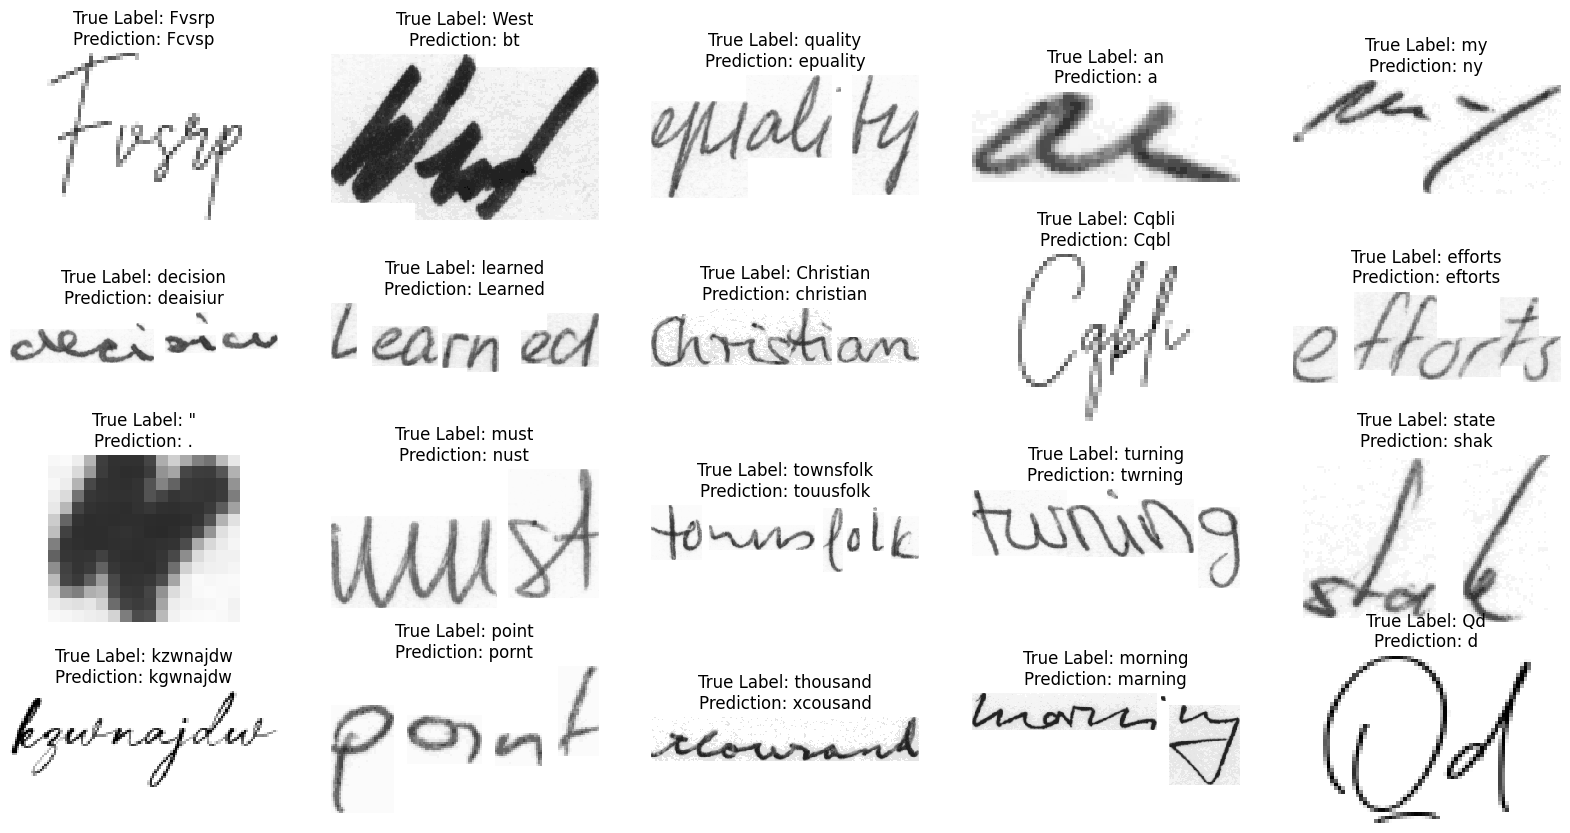

In [15]:
# Appercu des mots mal prédits
rd.show_words_predictions_errors(X_test, y_test, y_pred, predicted_transcriptions)

# => certains mots sont coupés, ou contiennent une faute d'orthographe/échange de lettres
    